## Content based Collaborative Filtering

## Importing Libaries & loading data & preprocessing

In [36]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import ast


In [37]:
def preprocess_contentbased_filtering(book_df):
    """
    Preprocess books for content-based filtering by selecting relevant columns,
    dropping rows with missing categories or descriptions, and creating a 
    combined text field with boosted genres.

    Args:
        book_df (pd.DataFrame): DataFrame with columns 'title', 'categories',
            and 'description'.

    Returns:
        pd.DataFrame: Preprocessed DataFrame with 'combined_text' column added.
    """
       
    book_df = book_df[['title', 'categories','description']]
    book_df.dropna(subset=["categories","description"], inplace=True)
    book_df['combined_text'] = book_df.apply(boost_genres,axis=1)
    return book_df

# boost genres for TF-IDF
def boost_genres(row, boost=3):
    """
    Boost genre terms within a book's text representation for TF-IDF.

    This function strengthens the influence of genre/category keywords
    by repeating them multiple times before concatenating them with the
    book description. This helps ensure that genre signals remain
    prominent during TF-IDF vectorization, especially when genres are
    rare or overshadowed by longer descriptions.

    Args:
        row (pd.Series): A row from the dataframe containing at least
            'description' and 'categories' fields.
        boost (int, optional): The number of times to repeat (boost) the
            genre text. Defaults to 5.

    Returns:
        str: A single lowercase text string composed of boosted genre
        keywords followed by the book description.
    """
    
    description = str(row['description']).lower()
    genres = str(row['categories']).lower()
    boosted_genres = (' ' + genres) * boost  # repeat genres
    return boosted_genres + description

In [38]:
# load processed books info
book_df = pd.read_csv('preprocessed_data/books.csv')

# preprocess for content based similarity
book_df = preprocess_contentbased_filtering(book_df)
 
# load processed reviews
review_df = pd.read_csv('preprocessed_data/reviews.csv')

C:\Users\insiy\AppData\Local\Temp\ipykernel_8512\3406422851.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df.dropna(subset=["categories","description"], inplace=True)
C:\Users\insiy\AppData\Local\Temp\ipykernel_8512\3406422851.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df['combined_text'] = book_df.apply(boost_genres,axis=1)


In [39]:
def create_tfidf_matrix(df, text_column='combined_text', 
                        min_df=50, max_df=0.7, max_features=300):
    """
    Create a TF-IDF matrix from a DataFrame's text column.

    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        text_column (str, optional): Name of the column with text. Default is 'combined_text'.
        min_df (int, optional): Minimum number of documents a term must appear in. Default is 50.
        max_df (float, optional): Maximum proportion of documents a term can appear in. Default is 0.7.
        max_features (int, optional): Maximum number of features to keep. Default is 300.
        extra_stop_words (set or list, optional): Additional words to ignore. Default is None.

    Returns:
        tuple: (vectorizer, tfidf_matrix)
            - vectorizer: fitted TfidfVectorizer object
            - tfidf_matrix: TF-IDF matrix for the text column
    """
    # Combine default stop words with any extra stop words
    stop_words = list(ENGLISH_STOP_WORDS.union({'&','book', 'novel', 'story','[',']'}))

    # Initialize vectorizer
    vectorizer = TfidfVectorizer(
        min_df=min_df,
        max_df=max_df,
        stop_words=stop_words,
        token_pattern=r"(?u)\b[a-zA-Z]+\b",
        max_features=max_features
    )

    # Fit and transform
    tfidf_matrix = vectorizer.fit_transform(df[text_column])

    return vectorizer, tfidf_matrix

def bayesian_scoring(reviews_df,C,m):
    """
    Calculate Bayesian scoring for books based on reviews.

    Args:
        reviews_df (pd.DataFrame): DataFrame with at least ['title', 'score'] columns.
        C (float): Confidence factor (e.g., average number of ratings).
        m (float): Global mean rating.

    Returns:
        pd.DataFrame: Books ranked by Bayesian score (highest first).
    """

    #step 1: create array with title, average rating of each book, and # of ratings
    books_avg_ratings = reviews_df.groupby(['title']).agg(
        avg_rating=('score', 'mean'),  
        num_ratings=('score', 'count') 
    ).reset_index()

    #step 2: bayesian score
    books_avg_ratings['bayesian_score'] = (
        (C * m + books_avg_ratings['num_ratings'] * books_avg_ratings['avg_rating']) /
        (C + books_avg_ratings['num_ratings'])
    )
    #step 3: rank the books based on their bayesian score
    books_ranked = books_avg_ratings.sort_values(
        by=['bayesian_score'], 
        ascending=False)
    
    return books_ranked

# find nearest neighbors (similar items) in a dataset instead of computing all pairwise distances
def fit_nearest_neighbors(tfidf_matrix, n_neighbors=100000, metric='cosine', algorithm='brute'):
    """
    Fit a NearestNeighbors model on a TF-IDF matrix.

    Args:
        tfidf_matrix (sparse matrix): TF-IDF representation of the items (books).
        n_neighbors (int, optional): Number of neighbors to return. Default is 1000.
        metric (str, optional): Distance metric to use. Default is 'cosine'.
        algorithm (str, optional): Algorithm for computing nearest neighbors. Default is 'brute'.

    Returns:
        NearestNeighbors: Fitted NearestNeighbors model.
    """
    nn = NearestNeighbors(
        n_neighbors=n_neighbors,
        metric=metric,
        algorithm=algorithm
    )
    
    nn.fit(tfidf_matrix)
    return nn


In [40]:
# computing the similarity
vectorizer, tfidf_matrix = create_tfidf_matrix(book_df)
C = 30 # Based on hyperparameter tuning
m = review_df['score'].mean() # Global mean
cold_start_books = bayesian_scoring(review_df, C, m)
nn = fit_nearest_neighbors(tfidf_matrix)


In [41]:
# user enters from a given list of genres
genres = [
    "Fiction","History","Religion","Biography & Autobiography",
    "Business & Economics","Computers","Social Science","Nonfiction",
    "Science","Education","Cooking","Sports & Recreation","Family & Relationships",
    "Literary Criticism","Music","Medical",
    "Body, Mind & Spirit","Health & Fitness","Language Arts & Disciplines"
    "Love","Fiction"
]

In [42]:
#Recommend books for a new user by selected genres
def recommend_for_new_user(selected_genres, vectorizer=vectorizer, nn=nn, df=book_df, top_n=10000, final_k = 10,boost=3):
    # Combine and boost genres
    user_text = (' '.join(selected_genres).lower() + ' ') * boost
    
    # Transform to TF-IDF
    user_vector = vectorizer.transform([user_text])
    
    # Find nearest neighbors
    distances, indices = nn.kneighbors(user_vector, n_neighbors=top_n)
    rec = df.iloc[indices[0]][['title', 'categories']]
    rec_df = rec.merge(cold_start_books, on='title',how='left')
    rec_df = rec_df.sort_values(by='bayesian_score',ascending=False)

    return rec_df[['title','categories','bayesian_score']].head(final_k)

Solving cold start

In [44]:
new_user_genres = ['science']
recommended_books = recommend_for_new_user(new_user_genres, final_k=5)
recommended_books

,title,categories,bayesian_score
8847,Prescription for Nutritional Healing: A Practi...,['Health & Fitness'],4.683841
1863,Black Like Me,['Social Science'],4.658758
8452,The Rediscovery of Man: The Complete Short Sci...,['Fiction'],4.648061
2831,Lakota Way: Stories & Lessons for Living,['Social Science'],4.638601
5620,The Girls Who Went Away: The Hidden History of...,['Social Science'],4.637971


## Few problems i faced  
1) Memory error when calculating cosine similarity -> instead used nearest neighbors
2) While running my code initially on jaccard metric i didnt understand why i was only recommedatons based on one genre -> turns out each book only had one genre
3) We could do jaccard metric on only one genre but that literaly just providing the user with genres they select, this is just filtering
4) Instead i combined the description with boost genres to create a combined TF-IDF model

### Ignore - Given we have a book and we want to find books similar to it


In [ ]:
# stores the cosine distance -> distance
# stores the indicies of closest books -> indices

# this is if we want to recommend based on similar book content

# We want to recommed books similar to this book
book_title = "Harry Potter & the Prisoner of Azkaban"

# Get index (returns a pandas Index object)
index = df[df['title'] == book_title].index[0]
print

book_title = df.iloc[index]['title']
print(f"Recommendations for book: {book_title}")

distances, indices = nn.kneighbors(tfidf_matrix[index])
recommended_books = df.iloc[indices[0][:]]
recommended_books.head(10)
print(f'Recommedation for book {99559}\n{recommended_books.head(3)}')


99559
Recommendations for book: The 8088 and 8086 Microprocessors: Programming Interfacing, Software, Hardware, and Applications (3rd Edition)
Recommedation for book 99559
                                                    title  \
150760  The 8088 and 8086 Microprocessors: Programming...   
16474   The Synerjet Engine: Airbreathing/Rocket Combi...   
134705  Steel, Concrete, and Composite Design of Tall ...   

                             categories  \
150760  ['Intel 8086 (Microprocessor)']   
16474                  ['Astronautics']   
134705     ['Technology & Engineering']   

                                              description  \
150760  For one-semester courses in Microprocessors. T...   
16474   Annotation "Design Methodologies for Space Tra...   
134705  Addresses the Question Frequently Proposed to ...   

                                            combined_text  
150760   ['intel 8086 (microprocessor)'] ['intel 8086 ...  
16474    ['astronautics'] ['astronautics'] ['

In [44]:
def recommend_similar_books(book_title, df=df, tfidf_matrix=tfidf_matrix, nn=nn, top_k=10):
    # Find the index of the book in df
    if book_title not in df['title'].values:
        raise ValueError(f"Book '{book_title}' not found in dataset.")
    
    index = df[df['title'] == book_title].index[0]

    # Find nearest neighbors
    distances, indices = nn.kneighbors(tfidf_matrix[index], n_neighbors=top_k+1)  # +1 to exclude itself

    # Get recommended books, excluding the original book
    recommended_indices = [i for i in indices[0] if i != index]
    recommended_books = df.iloc[recommended_indices][:top_k]

    print(f"Recommendations for book: {book_title}\n")
    for i, title in enumerate(recommended_books['title'], 1):
        print(f"{i}. {title}")
    
    return recommended_books

In [45]:
recommended_books = recommend_similar_books("Harry Potter & the Prisoner of Azkaban", top_k=10)

Recommendations for book: Harry Potter & the Prisoner of Azkaban

1. The Synerjet Engine: Airbreathing/Rocket Combined-Cycle Propulsion for Tomorrow's Space Transports (Progress in Technology)
2. Steel, Concrete, and Composite Design of Tall Buildings
3. Creatures Fantastic Video: Dragons
4. Typography
5. Publication Design Workbook: A Real-World Guide to Designing Magazines, Newspapers, and Newsletters
6. German Rocket Launchers in WWII: (Schiffer Military History)
7. The Comforts of Home: Creating Relaxed Rooms With A Romantic Feel
8. God's man: A novel in woodcuts
9. Fusion of Neural Networks, Fuzzy Systems and Genetic Algorithms: Industrial Applications (International Series on Computational Intelligence)
10. Arabic Typography


List of Genres user can select from

## Bayesian Scoring_Methodology

for the top 100 we want to get the bayesian score

In [ ]:
review_df.head()

,book_id,title,user_id,profile_name,helpfulness,score,review_date,summary,text,year
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,1999
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,2004
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",2004
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",2004
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,2005


In [ ]:
def bayesian_scoring(reviews_df,C,m):
    """
    Calculate Bayesian scoring for books based on reviews.

    Args:
        reviews_df (pd.DataFrame): DataFrame with at least ['title', 'score'] columns.
        C (float): Confidence factor (e.g., average number of ratings).
        m (float): Global mean rating.

    Returns:
        pd.DataFrame: Books ranked by Bayesian score (highest first).
    """

    #step 1: create array with title, average rating of each book, and # of ratings
    books_avg_ratings = reviews_df.groupby(['title']).agg(
        avg_rating=('score', 'mean'),  
        num_ratings=('score', 'count') 
    ).reset_index()

    #step 2: bayesian score
    books_avg_ratings['bayesian_score'] = (
        (C * m + books_avg_ratings['num_ratings'] * books_avg_ratings['avg_rating']) /
        (C + books_avg_ratings['num_ratings'])
    )
    #step 3: rank the books based on their bayesian score
    books_ranked = books_avg_ratings.sort_values(
        by=['bayesian_score'], 
        ascending=False)
    
    return books_ranked

In [30]:
#review_df['title'].value_counts().mean()

# Hypertune based on C
C_mean_reviews = review_df['title'].value_counts().mean()
C_values = [1, 2, 5, 10, C_mean_reviews,20, 30, 50, 75, 100, 150, 200]
m = review_df['score'].mean()


all_scores ={}
for C in C_values:
    ranked = bayesian_scoring(review_df,C,m)
    all_scores[C]= ranked[['title','bayesian_score']]


In [31]:
scores_pivot = None

for C in C_values:
    df_temp = all_scores[C].rename(columns={"bayesian_score": f"C_{C}"})
    
    if scores_pivot is None:
        scores_pivot = df_temp
    else:
        scores_pivot = scores_pivot.merge(df_temp, on="title", how="outer")
df_temp.head()

,title,C_200
190741,With the Old Breed: At Peleliu and Okinawa,4.747142
136948,Taking Charge of Your Fertility: The Definitiv...,4.702622
64747,Harry Potter & the Prisoner of Azkaban,4.700656
83930,Left to Tell: Discovering God Amidst The Rwand...,4.688942
118535,Redeeming Love,4.669250


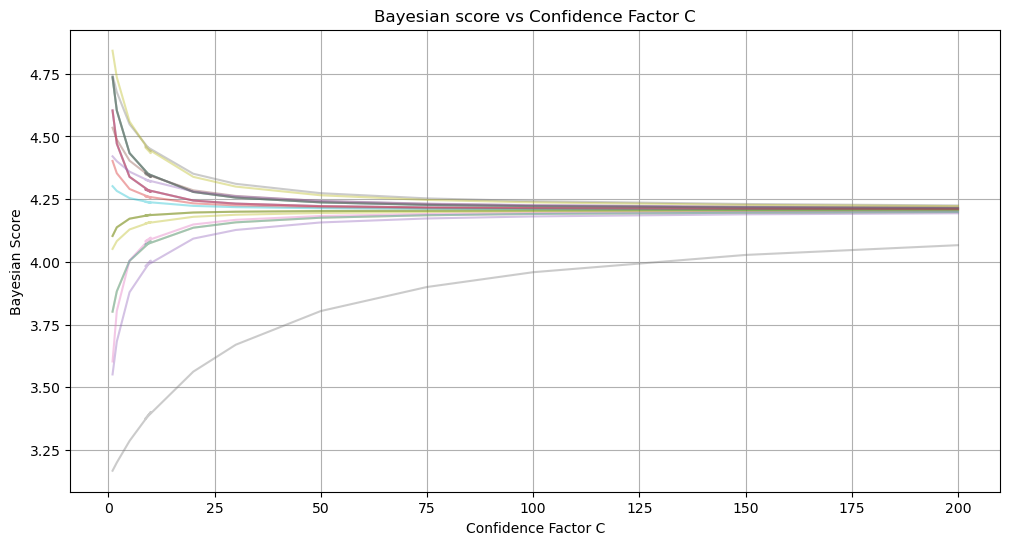

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sample_titles = scores_pivot['title'].sample(20)

for title in sample_titles:
    row = scores_pivot[scores_pivot['title'] == title].iloc[0]
    y = [row[f"C_{C}"] for C in C_values]
    plt.plot(C_values, y, alpha=0.4)

plt.title("Bayesian score vs Confidence Factor C")
plt.xlabel("Confidence Factor C")
plt.ylabel("Bayesian Score")
plt.grid(True)
plt.show()


In [33]:
topk_changes = []

for C in C_values:
    top20 = bayesian_scoring(review_df, C, m).head(15)['title'].tolist()
    topk_changes.append(top20)

pd.DataFrame(topk_changes, index=C_values)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1.000000,Lilla Belle: The First Stages,There Are Survivors: The Michael Cuccione Story,The Road to Guadalupe: A Modern Pilgrimage to ...,Angel Unaware: A Touching Story of Love and Loss,The ice people,The Hebrew Kid and the Apache Maiden,The Joyous Season,A Reason To Live : The True Story of One Woman...,The Four Laws of Debt Free Prosperity,Maximized Manhood,I Could've Written a Better Movie Than That! :...,Mending the Soul: Understanding and Healing Abuse,Sandbox Wisdom: Revolutionize Your Brand with ...,The Human Fabric: Unleashing the Power of Core...,Shibori: The Inventive Art of Japanese Shaped ...
2.000000,Lilla Belle: The First Stages,There Are Survivors: The Michael Cuccione Story,The Road to Guadalupe: A Modern Pilgrimage to ...,Angel Unaware: A Touching Story of Love and Loss,the lion's paw,The ice people,The Hebrew Kid and the Apache Maiden,The Joyous Season,The Four Laws of Debt Free Prosperity,A Reason To Live : The True Story of One Woman...,The Wealthy Spirit: Daily Affirmations for Fin...,Mending the Soul: Understanding and Healing Abuse,Maximized Manhood,I Could've Written a Better Movie Than That! :...,Sandbox Wisdom: Revolutionize Your Brand with ...
5.000000,Lilla Belle: The First Stages,the lion's paw,There Are Survivors: The Michael Cuccione Story,The Wealthy Spirit: Daily Affirmations for Fin...,"The Ferret Calendar 2005, Ferret Music",The Road to Guadalupe: A Modern Pilgrimage to ...,Golf in Scotland: A Travel-Planning Guide with...,Dancing the Dream: Poems and Reflections,"Why revival tarries,",Angel Unaware: A Touching Story of Love and Loss,With the Old Breed: At Peleliu and Okinawa,The Valley of Vision: a Collection of Puritan ...,shadow castle,Up Front,The Hebrew Kid and the Apache Maiden
10.000000,Lilla Belle: The First Stages,With the Old Breed: At Peleliu and Okinawa,"The Ferret Calendar 2005, Ferret Music",the lion's paw,The Wealthy Spirit: Daily Affirmations for Fin...,The Valley of Vision: a Collection of Puritan ...,Betty Crocker's cooky book,There Are Survivors: The Michael Cuccione Story,Dancing the Dream: Poems and Reflections,Golf in Scotland: A Travel-Planning Guide with...,CARS AND TRUCKS AND THINGS THAT GO,"Why revival tarries,",shadow castle,Azucar! The Story of Sugar,My Brother's Voice: How a Young Hungarian Boy ...
8.718975,Lilla Belle: The First Stages,the lion's paw,"The Ferret Calendar 2005, Ferret Music",With the Old Breed: At Peleliu and Okinawa,The Wealthy Spirit: Daily Affirmations for Fin...,The Valley of Vision: a Collection of Puritan ...,There Are Survivors: The Michael Cuccione Story,Golf in Scotland: A Travel-Planning Guide with...,Dancing the Dream: Poems and Reflections,Betty Crocker's cooky book,"Why revival tarries,",shadow castle,The Road to Guadalupe: A Modern Pilgrimage to ...,CARS AND TRUCKS AND THINGS THAT GO,Azucar! The Story of Sugar
20.000000,With the Old Breed: At Peleliu and Okinawa,Lilla Belle: The First Stages,"The Ferret Calendar 2005, Ferret Music",The Valley of Vision: a Collection of Puritan ...,Betty Crocker's cooky book,CARS AND TRUCKS AND THINGS THAT GO,The Wealthy Spirit: Daily Affirmations for Fin...,the lion's paw,Tear Soup: A Recipe for Healing After Loss,Where the Sidewalk Ends: Poems and Drawings,Harrington on Hold 'em Expert Strategy for No ...,Left to Tell: Discovering God Amidst The Rwand...,My Brother's Voice: How a Young Hungarian Boy ...,The Lost Years: Surviving a Mother and Daughte...,The Gruffalo (Picture Books)
30.000000,With the Old Breed: At Peleliu and Okinawa,"The Ferret Calendar 2005, Ferret Music",Lilla Belle: The First Stages,Betty Crocker's cooky book,The Valley of Vision: a Collection of Puritan ...,CARS AND TRUCKS AND THINGS THAT GO,Tear Soup: A Recipe for Healing After Loss,Where the Sidewalk Ends: Poems and Drawings,Left to Tell: Discovering God Amidst The Rwand...,Harrington on Hold 'em Expert Strategy for No ...,The monster at the end of this book (A little ...,Taking Charge of Yo

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


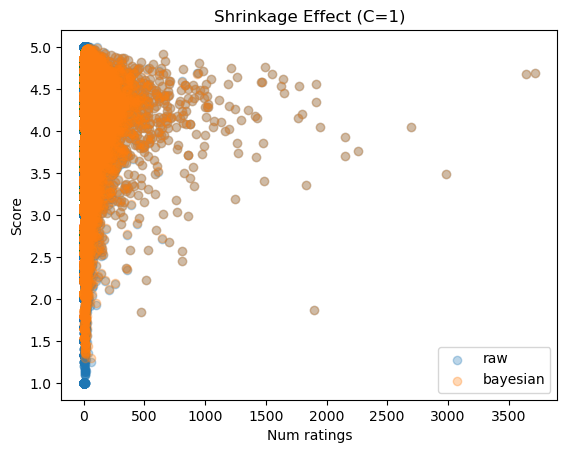

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


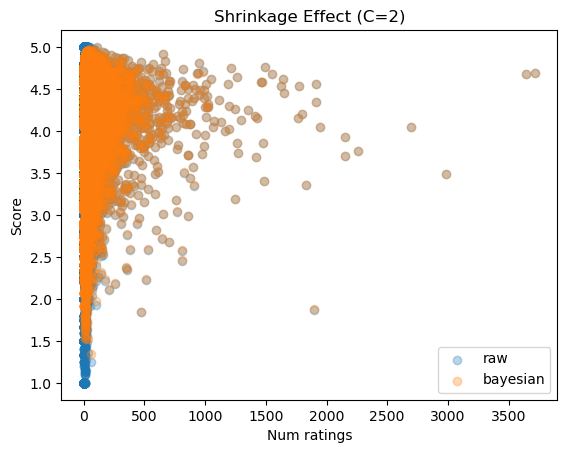

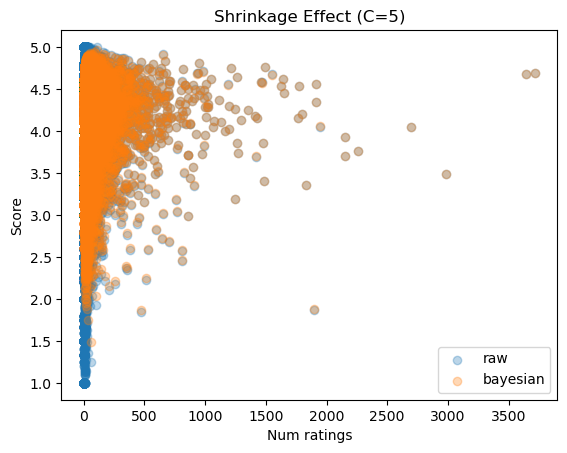

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


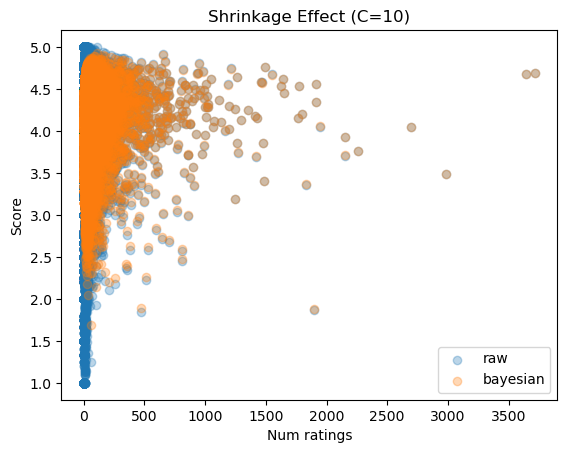

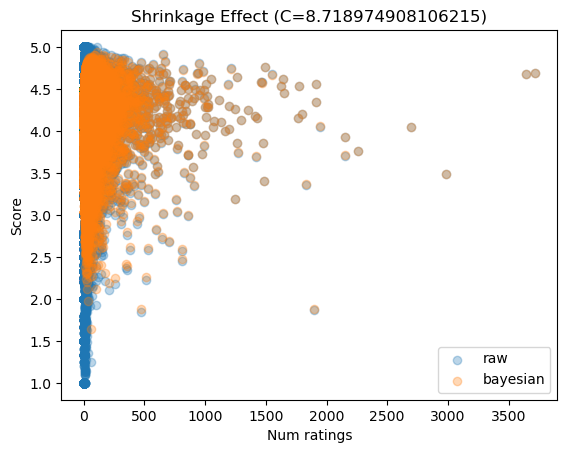

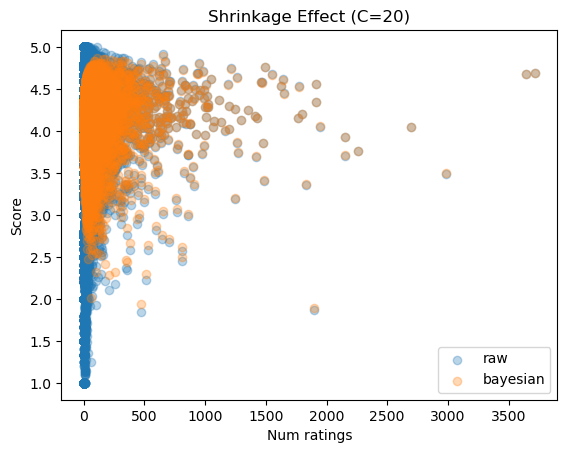

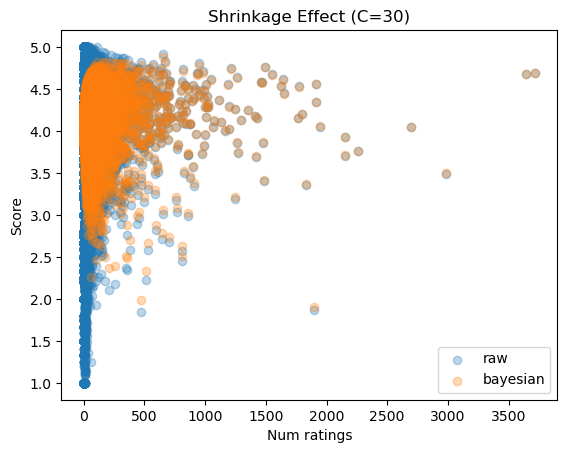

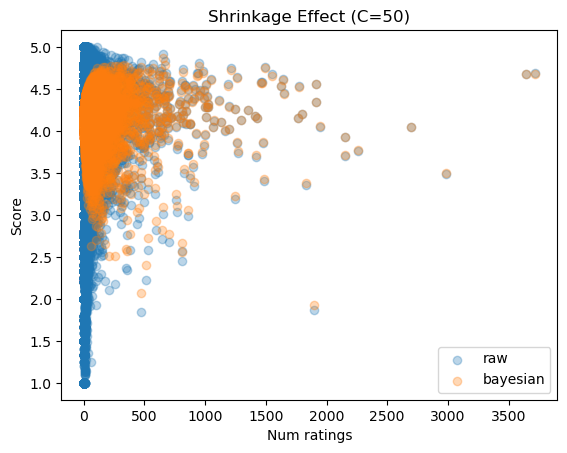

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


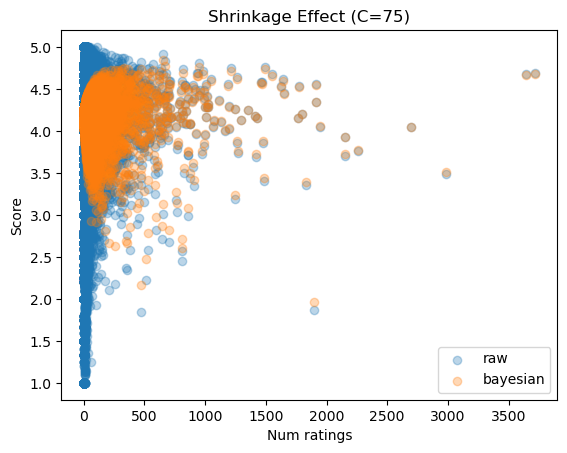

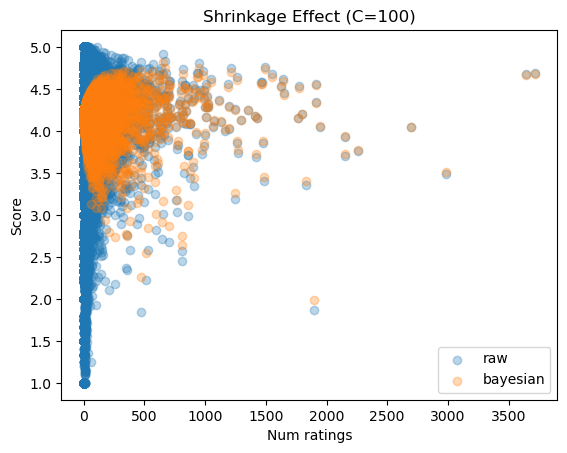

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


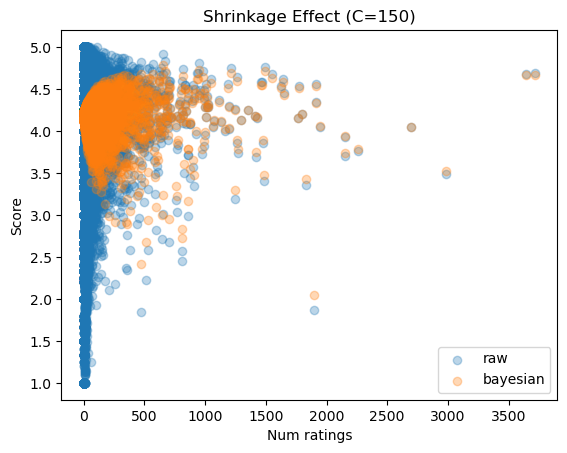

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


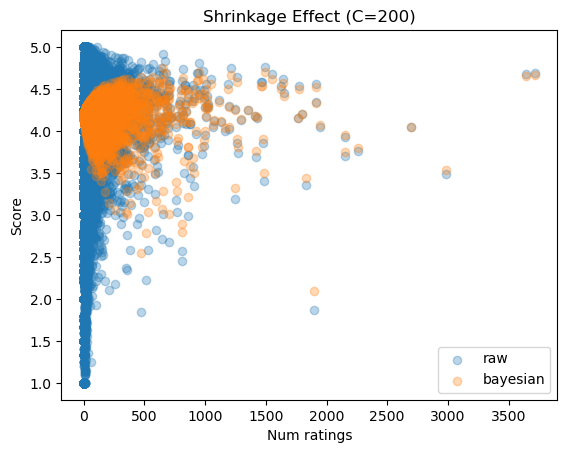

In [34]:
books = review_df.groupby('title').agg(
    avg_rating=('score', 'mean'),
    num_ratings=('score', 'count')
).reset_index()


for C in C_values:
    books['bayes'] = (C*m + books['num_ratings']*books['avg_rating']) / (C + books['num_ratings'])

    plt.scatter(books['num_ratings'], books['avg_rating'], alpha=0.3, label='raw')
    plt.scatter(books['num_ratings'], books['bayes'], alpha=0.3, label='bayesian')
    plt.xlabel("Num ratings")
    plt.ylabel("Score")
    plt.title(f"Shrinkage Effect (C={C})")
    plt.legend()
    plt.show()


